In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Process_Monitoring_2022-2023/IPM Project')
!ls

Mounted at /content/drive
'Battery RULRVE.ipynb'	 data	  logs	     original_data   test.ipynb
 checkpoints		 images   model.py   __pycache__


# **Libraries**

In [ ]:
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import layers
from sklearn.svm import SVR
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector, Bidirectional, Masking, Dropout, BatchNormalization

# **Reading data**

In [ ]:
# Data reading
data_dir = './original_data/'

# Specify the file path and column names
file_path = os.path.join(data_dir, 'battery_RUL.txt')

# Specify the column names
column_names = [
    'unit_nr',
    'time_cycles',
    's_discharge_t',
    's_decrement_3.6-3.4V',
    's_max_voltage_discharge',
    's_min_voltage_charge',
    'Time_at_4.15V_s',
    's_time_constant_current',
    's_charging_time',
    'RUL'
]

# Read the text file into a DataFrame
df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=0, names=column_names)

# Calculate the unique number of batteries
unique_batteries = df['unit_nr'].nunique()
print("\n Unique number of batteries:", unique_batteries)

# Check for missing values
if df.isnull().any().any():
    print("\n There are missing values in the DataFrame.")

# Print the shape of the DataFrame
print("\n DataFrame shape:", df.shape)

# print df info
print(df.info())

# Print the first few rows of the DataFrame
print("\n First few rows of the DataFrame:")
df.head()


 Unique number of batteries: 14

 DataFrame shape: (15064, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unit_nr                  15064 non-null  float64
 1   time_cycles              15064 non-null  float64
 2   s_discharge_t            15064 non-null  float64
 3   s_decrement_3.6-3.4V     15064 non-null  float64
 4   s_max_voltage_discharge  15064 non-null  float64
 5   s_min_voltage_charge     15064 non-null  float64
 6   Time_at_4.15V_s          15064 non-null  float64
 7   s_time_constant_current  15064 non-null  float64
 8   s_charging_time          15064 non-null  float64
 9   RUL                      15064 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.1 MB
None

 First few rows of the DataFrame:


,unit_nr,time_cycles,s_discharge_t,s_decrement_3.6-3.4V,s_max_voltage_discharge,s_min_voltage_charge,Time_at_4.15V_s,s_time_constant_current,s_charging_time,RUL
0,1.0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,1.0,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,1.0,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,1.0,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,1.0,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


# **Data Pre-Processing**

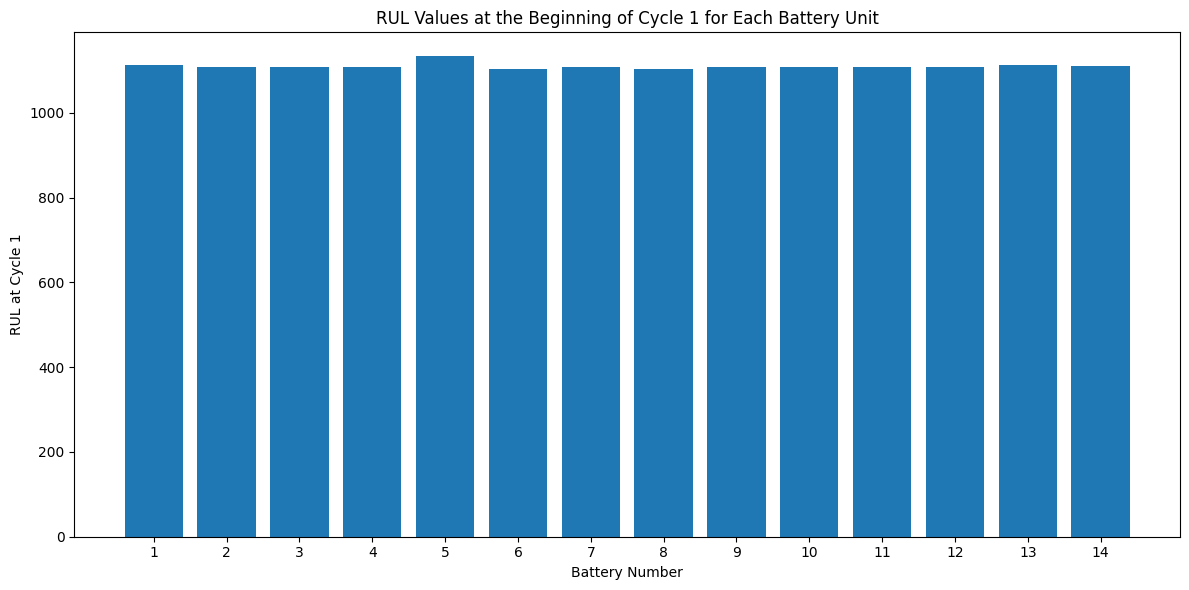

In [ ]:
# Filter rows where 'time_cycles' is equal to 1
df_at_cycle_1 = df[df['time_cycles'] == 1]

# Create a bar chart with all battery units on the X-axis
plt.figure(figsize=(12, 6))
plt.bar(df_at_cycle_1['unit_nr'], df_at_cycle_1['RUL'])
plt.xlabel('Battery Number')
plt.ylabel('RUL at Cycle 1')
plt.title('RUL Values at the Beginning of Cycle 1 for Each Battery Unit')
plt.xticks(df_at_cycle_1['unit_nr'])  # Set X-axis ticks explicitly
plt.tight_layout()
plt.show()

<Axes: >

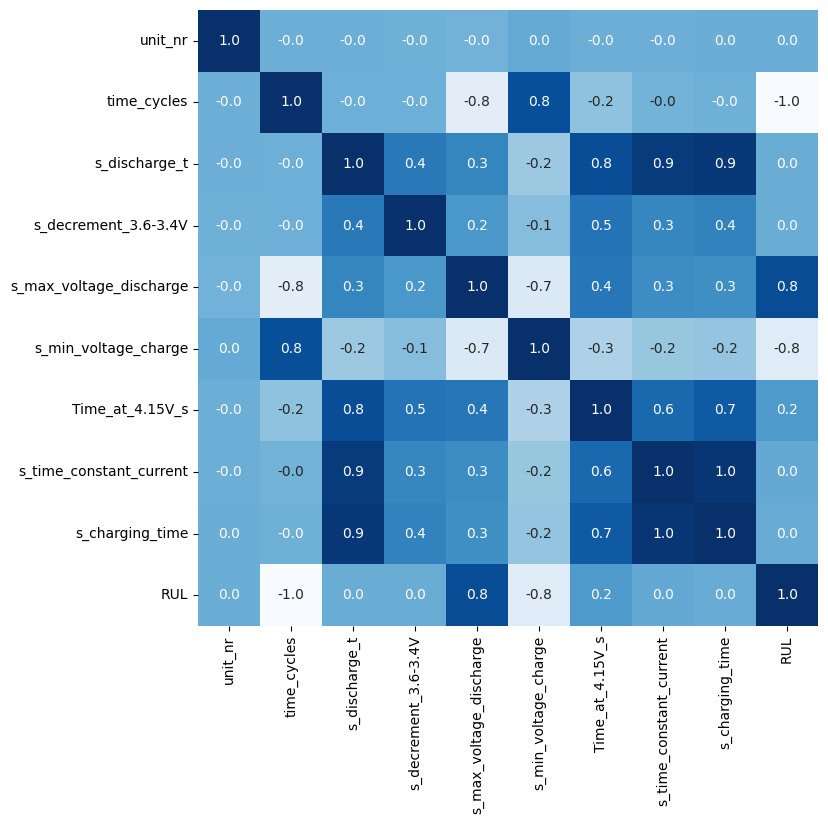

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

**Correlation between RUL and:**

Max. Voltage Dischar. (V) is 0.8

Min. Voltage Charg. (V) is -0.8

Time at 4.15V (s) is 0.2

Cycle index is -1.0

Discharge Time (s), Decrement 3.6-3.4V (s), Time constant current (s) and Charging time (s) are 0.

And correlation between Time at 4.15V and these four features are 0.8, 0.5,0.6 and 0.7.

In [ ]:
df1=df.drop(['s_discharge_t', 's_decrement_3.6-3.4V', 's_time_constant_current','s_charging_time'], axis=1)

<Axes: >

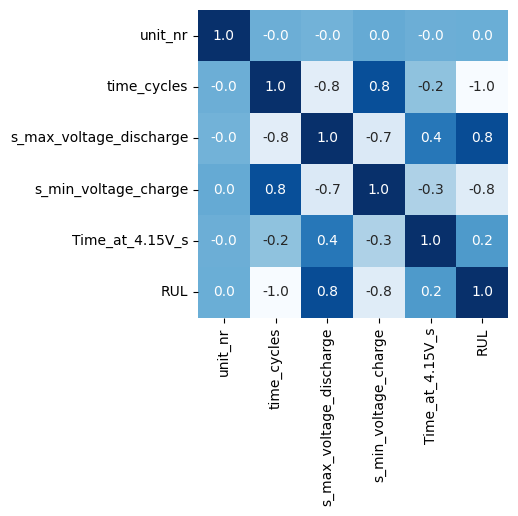

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(df1.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [ ]:
df1.head()

,unit_nr,time_cycles,s_max_voltage_discharge,s_min_voltage_charge,Time_at_4.15V_s,RUL
0,1.0,1.0,3.670,3.211,5460.001,1112
1,1.0,2.0,4.246,3.220,5508.992,1111
2,1.0,3.0,4.249,3.224,5508.993,1110
3,1.0,4.0,4.250,3.225,5502.016,1109
4,1.0,6.0,4.290,3.398,5480.992,1107


In [ ]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr', group_keys=True)[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)

    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df
#-----------------------------------------------------------------------------------------------------------------------
def data_standardization(df, sensors):
    df = df.copy()
    # Apply StandardScaler to the sensor data
    scaler = StandardScaler()
    df[sensors] = scaler.fit_transform(df[sensors])

    return df

    # MMS_X = MinMaxScaler()
    # mms_y = MinMaxScaler()
#-----------------------------------------------------------------------------------------------------------------------
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
#-----------------------------------------------------------------------------------------------------------------------
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array
#-----------------------------------------------------------------------------------------------------------------------
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]
#-----------------------------------------------------------------------------------------------------------------------
def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array
#---------Original code------------------------------------------------------------------------------------------------------
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]
#---------------------------------------------------------------------------------------------------------------------------
def change_test_index(df, initial_unit_number, start_index, end_index, min_rows, max_rows):
    df.reset_index(drop=True, inplace=True)
    y_test = []  # Initialize an empty list to store y_test values
    y_test.append(df.loc[0, 'RUL'])

    while end_index < len(df):
        # Calculate the number of rows to be assigned to the current unit_nr
        num_rows = min_rows + (end_index % (max_rows - min_rows + 1))
        end_index = end_index + num_rows

        # Update the unit_nr for the current block of rows
        df.loc[start_index:end_index, 'unit_nr'] = initial_unit_number

        # Update the "time_cycles" column starting from the first row with "time_cycles" == 1
        time_cycle_to_change = end_index + 1
        df.loc[time_cycle_to_change, 'time_cycles'] = 1

        # Append the values to y_test (replace 'column_name' with the actual column name you want to append)
        y_test.append(df.loc[time_cycle_to_change, 'RUL'])

        # Update the starting and ending index for the next block of rows
        start_index = end_index + 1
        initial_unit_number += 1

    # Drop rows with NaN values at the end of DataFrame 'df'
    df.dropna(axis=0, how='any', inplace=True)

    # Drop any NaN values at the end of list 'y_test'
    while len(y_test) > 0 and pd.isnull(y_test[-1]):
        y_test.pop()

    return df, y_test

# **Get data**

In [ ]:
def get_data(df, sensors, sequence_length, alpha):
    # List of battery units
    battery_units = range(1, 15)
    sensor_names = ['s_{}'.format(i+1) for i in range(0,10)]
    # Define the number of batteries for training and testing
    train_batteries = 12
    test_batteries = 2

    # Extract the batteries for training and testing
    train_units = battery_units[:train_batteries]
    test_units = battery_units[train_batteries:train_batteries + test_batteries]

    # Create the training and testing datasets
    train = df[df['unit_nr'].isin(train_units)].copy()  # Use copy to avoid the SettingWithCopyWarning
    test = df[df['unit_nr'].isin(test_units)].copy()  # Use copy to avoid the SettingWithCopyWarning

    X_test_pre, y_test = change_test_index(test, 13, 0, 0, 230, 240)

    # y_test = pd.Series(y_test)  # Convert y_test list to a pandas Series

    # remove unused sensors
    drop_sensors = [element for element in sensor_names if element not in sensors]

    # Apply standardization to the training and testing data using data_standardization function
    standard_train = data_standardization(train, sensors)
    standard_test = data_standardization(test, sensors)

    # Exponential smoothing of training and testing data
    X_train_pre = exponential_smoothing(standard_train, sensors, 0, alpha)
    X_test_pre = exponential_smoothing(standard_test, sensors, 0, alpha)

    # Train-validation split
    gss = GroupShuffleSplit(n_splits=1, train_size=0.85, random_state=42)
    # Generate the train/val for each sample by iterating over the train and val units
    for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()):
        train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        val_unit = X_train_pre['unit_nr'].unique()[val_unit]

        x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
        y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)

        x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
        y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)

    # create sequences for test
    test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
			  for unit_nr in X_test_pre['unit_nr'].unique())

    x_test = np.concatenate(list(test_gen)).astype(np.float32)

    return x_train, y_train, x_val, y_val, x_test, y_test



# **Training Callbacks**

In [ ]:
# --------------------------------------- TRAINING CALLBACKS  ---------------------------------------
class save_latent_space_viz(Callback):
	def __init__(self, model, data, target):
		self.model = model
		self.data = data
		self.target = target

	def on_train_begin(self, logs={}):
		self.best_val_loss = 100000

	def on_epoch_end(self, epoch, logs=None):
		encoder = self.model.layers[0]
		if logs.get('val_loss') < self.best_val_loss:
			self.best_val_loss = logs.get('val_loss')
			viz_latent_space(encoder, self.data, self.target, epoch, True, False)

def get_callbacks(model, data, target):
	model_callbacks = [
		EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
        ModelCheckpoint(filepath='./checkpoints/checkpoint',monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True),
		TensorBoard(log_dir='./logs'),
        save_latent_space_viz(model, data, target)
	]
	return model_callbacks

def viz_latent_space(encoder, data, targets=[], epoch='Final', save=False, show=True):
    z, _, _  = encoder.predict(data)
    plt.figure(figsize=(3, 3))  # Smaller figsize value to reduce the plot size
    if len(targets) > 0:
        plt.scatter(z[:, 1], z[:, 0],  c=targets)
    else:
        plt.scatter(z[:, 1], z[:, 0])
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    if show:
        plt.show()
    if save:
        plt.savefig('./images/latent_space_epoch' + str(epoch) + '.png')
    return z
# ---------------------------------------------------------------------------------------------------

# **Find Optimal Learning-rate**

In [ ]:
# ----------------------------------------- FIND OPTIMAL LR  ----------------------------------------
class LRFinder:
    """
    Cyclical LR, code tailored from:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]
# ---------------------------------------------------------------------------------------------------

# **Results**

In [ ]:
# --------------------------------------------- RESULTS  --------------------------------------------
def get_model(path):
    saved_VRAE_model = load_model(path, compile=False)

    # return encoder, regressor
    return saved_VRAE_model.layers[1], saved_VRAE_model.layers[2]

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse, variance

def score(y_true, y_hat):
  res = 0
  for true, hat in zip(y_true, y_hat):
    subs = hat - true
    if subs < 0:
      res = res + np.exp(-subs/10)[0]-1
    else:
      res = res + np.exp(subs/13)[0]-1
  print("score: ", res)

def results(path, x_train, y_train, x_test, y_test):
    # Get model
    encoder, regressor = get_model(path)
    # Latent space
    train_mu = viz_latent_space(encoder, x_train, y_train)
    test_mu = viz_latent_space(encoder, x_test, y_test)
    # Evaluate
    y_hat_train = regressor.predict(train_mu)
    y_hat_test = regressor.predict(test_mu)

    evaluate(y_train, y_hat_train, 'train')
    evaluate(y_test, y_hat_test, 'test')
    score(y_test, y_hat_test)
# ---------------------------------------------------------------------------------------------------

# **Model Architecture**

In [ ]:
class Sampling(keras.layers.Layer):
  """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * epsilon

In [ ]:
class RVE(keras.Model):
    def __init__(self, encoder, regressor, decoder=None, **kwargs):
        super(RVE, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        self.decoder = decoder
        if self.decoder!=None:
          self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")


    @property
    def metrics(self):
      if self.decoder!=None:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
            self.reconstruction_loss_tracker
        ]
      else:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
        ]

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            # Reconstruction
            if self.decoder!=None:
              reconstruction = self.decoder(z)
              reconstruction_loss = tf.reduce_mean(
                  keras.losses.mse(x, reconstruction)
              )
              total_loss = kl_loss + reg_loss + reconstruction_loss
              self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            else:
              total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        # Reconstruction
        if self.decoder!=None:
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(
              keras.losses.mse(x, reconstruction)
          )

          total_loss = kl_loss + reg_loss + reconstruction_loss
        else:
          total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "reg_loss": reg_loss,
        }

# **Main**

In [ ]:
# Set hyperparameters
sequence_length = 200
alpha = 0.2

# Load and preprocess data
df = df  # Load dataset
sensors = ['s_max_voltage_discharge', 's_min_voltage_charge', "Time_at_4.15V_s"] # Define the sensors

# Call get_data_with_kfold to get the necessary data
x_train, y_train, x_val, y_val, x_test, y_test = get_data(df1, sensors, sequence_length, alpha)

# from scipy.signal import savgol_filter
# # Apply Savitzky-Golay filter
# x_val_smoothed = savgol_filter(x_val, window_length=4, polyorder=2, axis=0)

# Setup the network parameters:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 32
batch_size = 256
latent_dim = 2
masking_value = -99 # used to mask values in sequences with less than 250 cycles until 250 is reached
kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
dropout_rate = 0.1
# --------------------------------- Encoder --------------------------------------
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')
mask = Masking(mask_value=masking_value)(inputs)
h = Bidirectional(LSTM(intermediate_dim))(mask) # LSTM encoding

mu = Dense(latent_dim, kernel_regularizer = kernel_regularizer)(h) # VAE Z layer
mu = Dropout(dropout_rate)(mu)

sigma = Dense(latent_dim, kernel_regularizer = kernel_regularizer)(h)
sigma = Dropout(dropout_rate)(sigma)

z = Sampling()([mu, sigma])

# Instantiate the encoder model:
encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')
# ------------------------------- Regressor --------------------------------------
reg_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_reg')

reg_intermediate = Dense(16, activation='tanh', kernel_regularizer = kernel_regularizer)(reg_latent_inputs)
reg_intermediate = BatchNormalization()(reg_intermediate)
reg_intermediate = Dropout(dropout_rate)(reg_intermediate)

reg_outputs = Dense(1, name='reg_output', kernel_regularizer = kernel_regularizer)(reg_intermediate)
reg_outputs = Dropout(dropout_rate)(reg_outputs)

# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", len(y_test))

Shape of x_train: (8795, 200, 3)
Shape of y_train: (8795, 1)
Shape of x_val: (1758, 200, 3)
Shape of y_val: (1758, 1)
Shape of x_test: (10, 200, 3)
Shape of y_test: 10


# **Finding the best LR**

Epoch 1/10
35/35 [==============================] - 24s 377ms/step - loss: 277636.3976 - kl_loss: 0.0325 - reg_loss: 271821.1562
Epoch 2/10
35/35 [==============================] - 13s 375ms/step - loss: 271093.0486 - kl_loss: 0.0324 - reg_loss: 272442.8438
Epoch 3/10
35/35 [==============================] - 13s 374ms/step - loss: 270847.0117 - kl_loss: 0.0315 - reg_loss: 273131.2812
Epoch 4/10
35/35 [==============================] - 11s 325ms/step - loss: 272087.7144 - kl_loss: 0.0275 - reg_loss: 271721.8438
Epoch 5/10
35/35 [==============================] - 12s 347ms/step - loss: 269831.6823 - kl_loss: 0.0208 - reg_loss: 272153.3750
Epoch 6/10
35/35 [==============================] - 13s 373ms/step - loss: 268869.0382 - kl_loss: 5.9367 - reg_loss: 270507.4062
Epoch 7/10
35/35 [==============================] - 14s 399ms/step - loss: 264492.0174 - kl_loss: 104.6599 - reg_loss: 262387.9375
Epoch 8/10
35/35 [==============================] - 15s 427ms/step - loss: 231600.5551 - kl_los

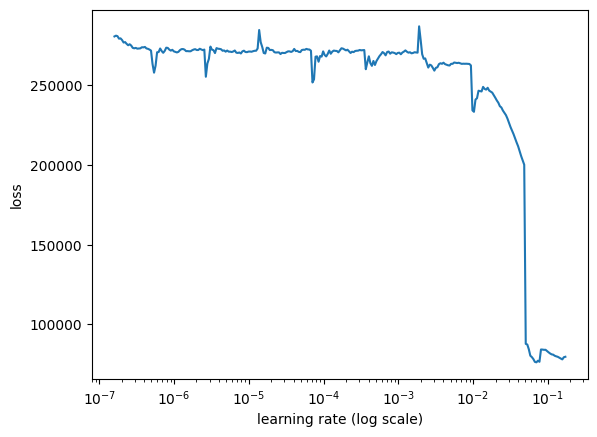

In [ ]:
rve = RVE(encoder, regressor)
lr_finder = LRFinder(rve)

rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000001))

# with learning rate growing exponentially from 0.0000001 to 1
lr_finder.find(x_train, y_train, start_lr=0.0000001, end_lr=1, batch_size=batch_size, epochs=10)

# Plot the loss
lr_finder.plot_loss()

# **Train**

In [ ]:
# Instantiate the RVE model
rve = RVE(encoder, regressor)

#Compile the RVE model with the Adam optimizer
rve.compile(optimizer=keras.optimizers.Adam(0.01))

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='loss', min_delta=3, patience=5,  verbose=1, mode='min', restore_best_weights=True)

# Call get_data_with_kfold to get the necessary data
x_train, y_train, x_val, y_val, x_test, y_test = get_data(df1, sensors, sequence_length, alpha)

# Fit the RVE model with the callbacks
rve.fit(x_train, y_train, epochs=500, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/500
35/35 [==============================] - 27s 484ms/step - loss: 2445.2584 - kl_loss: 16.9786 - reg_loss: 1460.3075 - val_loss: 25946.1484 - val_kl_loss: 13.4023 - val_reg_loss: 25932.7461
Epoch 2/500
35/35 [==============================] - 14s 410ms/step - loss: 502.5476 - kl_loss: 17.0434 - reg_loss: 427.5620 - val_loss: 18190.2090 - val_kl_loss: 13.2020 - val_reg_loss: 18177.0078
Epoch 3/500
35/35 [==============================] - 14s 410ms/step - loss: 349.3252 - kl_loss: 16.8034 - reg_loss: 320.2492 - val_loss: 18669.1445 - val_kl_loss: 13.0426 - val_reg_loss: 18656.1016
Epoch 4/500
35/35 [==============================] - 14s 410ms/step - loss: 281.9942 - kl_loss: 16.5141 - reg_loss: 250.0909 - val_loss: 14266.5791 - val_kl_loss: 13.3930 - val_reg_loss: 14253.1865
Epoch 5/500
35/35 [==============================] - 14s 409ms/step - loss: 242.3708 - kl_loss: 16.4962 - reg_loss: 220.1975 - val_loss: 17750.5410 - val_kl_loss: 13.1978 - val_reg_loss: 17737.3438
Epoch 6/

# **Evaluation**

330/330 [==============================] - 15s 45ms/step


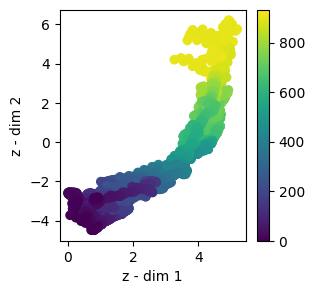

1/1 [==============================] - 0s 43ms/step


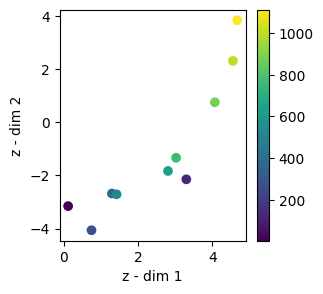

1/1 [==============================] - 0s 20ms/step
train set RMSE:26.346721649169922, R2:0.9899616368349312
test set RMSE:246.51723899515346, R2:0.5192274671464132


(246.51723899515346, 0.5192274671464132)

In [ ]:
train_mu = viz_latent_space(rve.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = viz_latent_space(rve.encoder, x_test, y_test)

# Evaluate
y_hat_train = rve.regressor.predict(train_mu)
y_hat_test = rve.regressor.predict(test_mu)

evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
evaluate(y_test, y_hat_test, 'test')